# Information Retrieval Coursework (7071CEM)

Task:
Whether as a separate program or integrated with search engine, a subject classification functionality is needed. More specifically, the input is a scientific text and the output is its subject among zero or more of the cases: Health, Engineering, Business, Art.

This program implements a text classifier using a NLP techniques and a selection of classification algorithms.

Based on the datasets sourced, the three chosen classifications are:

* Business
* Health
* Sports

## Imports

In [35]:
import os
import string

# Data Handling and Processing
import pandas as pd
import numpy as np
import re
from scipy import interp


# Visualuzation
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

# NLP Packages
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import nltk
from joblib import dump, load


# ML Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier

# Scikit Learn packages
from sklearn.base import clone
from sklearn.preprocessing import label_binarize, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import KFold, cross_validate, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import roc_curve, auc


# Load Datasets

In [36]:
text_df = pd.DataFrame(columns=['Text','Class'])
# text_df.to_csv('news_df.csv')
text_df.head()

,Text,Class


In [37]:
# Function to read the text files into one dataframe
def readfiles_to_dataframe(directory, category):
    arr = os.listdir(directory)
    strtext = ".txt"
    for textfile in arr:
        if textfile.__contains__(strtext):
            fileObject = open(directory + textfile, "r")
            data = fileObject.read()
            ouvert = pd.read_csv('abc.csv', index_col="Unnamed: 0")
            ouvert = ouvert.append({"Class": str(category), "Text": data},ignore_index=True)
            ouvert.to_csv('abc.csv')   

# Define categories             
# paths = [business_path, tech_path, arts_path]
# categories = ['business', 'tech', 'arts']


# # Call readfile function
# for path,category in zip(paths, categories):
#     readfiles_to_dataframe(path, category)

In [38]:
full_df = pd.read_csv('abc.csv')
print(full_df.shape)
full_df.head()

(89, 3)


,Unnamed: 0,Text,Class
0,0.0,japanese workers have seen their pay go up at ...,Business
1,1.0,tech billionaires mark zuckerberg elon musk ha...,Business
2,2.0,sales of smart speakers have fallen off a clif...,Business
3,3.0,chinas largest car manufacturer saic motor say...,Business
4,4.0,food prices not rising as fast as they were he...,Business


In [39]:
full_df.drop(columns=['Unnamed: 0'], inplace=True)
full_df.head()

,Text,Class
0,japanese workers have seen their pay go up at ...,Business
1,tech billionaires mark zuckerberg elon musk ha...,Business
2,sales of smart speakers have fallen off a clif...,Business
3,chinas largest car manufacturer saic motor say...,Business
4,food prices not rising as fast as they were he...,Business


## 1. Dataset Exploration

Text(0.5, 1.0, 'Number of News articles per Category')

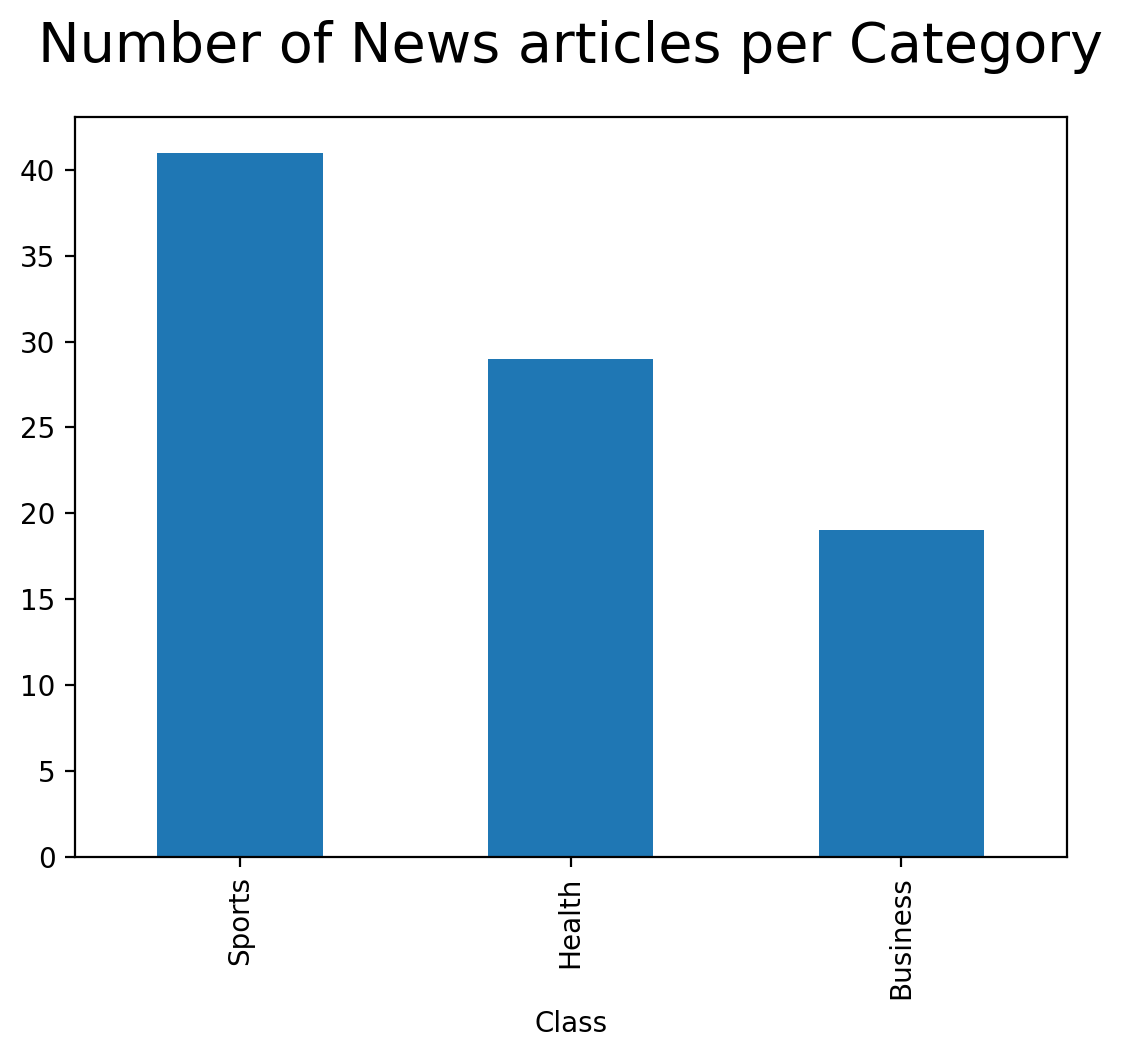

In [40]:
full_df['Class'].value_counts().plot(kind='bar')
plt.title('Number of News articles per Category', size=20, pad=20)

In [41]:
# Check for missing values
full_df.isna().sum()

Text     0
Class    0
dtype: int64

## 2. Text Preprocessing

Here, unwanted parts of the text are removed such as special characters. 

In [42]:
def preprocess(df):
    # Remove special characters
    df['Text2'] = df['Text'].replace('\n',' ')
    df['Text2'] = df['Text2'].replace('\r',' ')
    
    # Remove punctuation signs and lowercase all
    df['Text2'] = df['Text2'].str.lower()
    df['Text2'] = df['Text2'].str.translate(str.maketrans('', '', string.punctuation))
    
    
    # Remove stop words
    stop_words = stopwords.words("english")
    lemmatizer = WordNetLemmatizer()
    
    def fwpt(each):
        tag = pos_tag([each])[0][1][0].upper()
        hash_tag = {"N": wordnet.NOUN,"R": wordnet.ADV, "V": wordnet.VERB,"J": wordnet.ADJ}        
        return hash_tag.get(tag, wordnet.NOUN)

    
    def lematize(text):
        tokens = nltk.word_tokenize(text)
        ax = ""
        for each in tokens:
            if each not in stop_words:
                ax += lemmatizer.lemmatize(each, fwpt(each)) + " "
        return ax
    
    df['Text2'] = df['Text2'].apply(lematize)

In [43]:
preprocess(full_df)

### Demonstration of Preprocessing

**Original:**

In [44]:
full_df.iloc[1]['Text']

'tech billionaires mark zuckerberg elon musk have been joking about setting up a cage match in business world fight has already begun less than a day after mr zuckerberg launched his alternative to twitter threads it had already claimed some some million signups lending it credibility as a serious contender in world of social media thats still a small fraction of hundreds of millions of twitter users but analysts think its a sign that mr zuckerbergs meta has a good shot at wooing some of its gigantic billionplus users on facebook instagram whatsapp to new offering bringing advertisers with them after all mr zuckerberg whose meta made more than bn in sales last year has a monster track record when it comes to selling adverts none of apparent qualms of mr musk who has disdained advertising at his electric car company tesla been looking for alternative ways to fund twitter mr zuckerberg said there would be no ads on threads initially giving company time to finetune app which allows users 

**Processed:**

In [45]:
full_df.iloc[1]['Text2']

'tech billionaire mark zuckerberg elon musk joking set cage match business world fight already begin less day mr zuckerberg launch alternative twitter thread already claimed million signups lending credibility serious contender world social medium thats still small fraction hundred million twitter user analyst think sign mr zuckerbergs meta good shot woo gigantic billionplus user facebook instagram whatsapp new offering bring advertiser mr zuckerberg whose meta make bn sale last year monster track record come sell advert none apparent qualm mr musk disdain advertising electric car company tesla look alternative way fund twitter mr zuckerberg say would ad thread initially give company time finetune app allows user scroll endlessly textbased post approach product make product work well first see get clear path billion people think monetization point write eventually thread advert could add metas overall revenue generate bn optimistic scenario justin patterson equity research analyst keyb

## 3. Train Test Split

In [46]:
X_train, X_test, y_train, y_test = train_test_split(full_df['Text2'], 
                                                    full_df['Class'], 
                                                    test_size=0.2, 
                                                    random_state=9)

#### Check for acceptable category balance

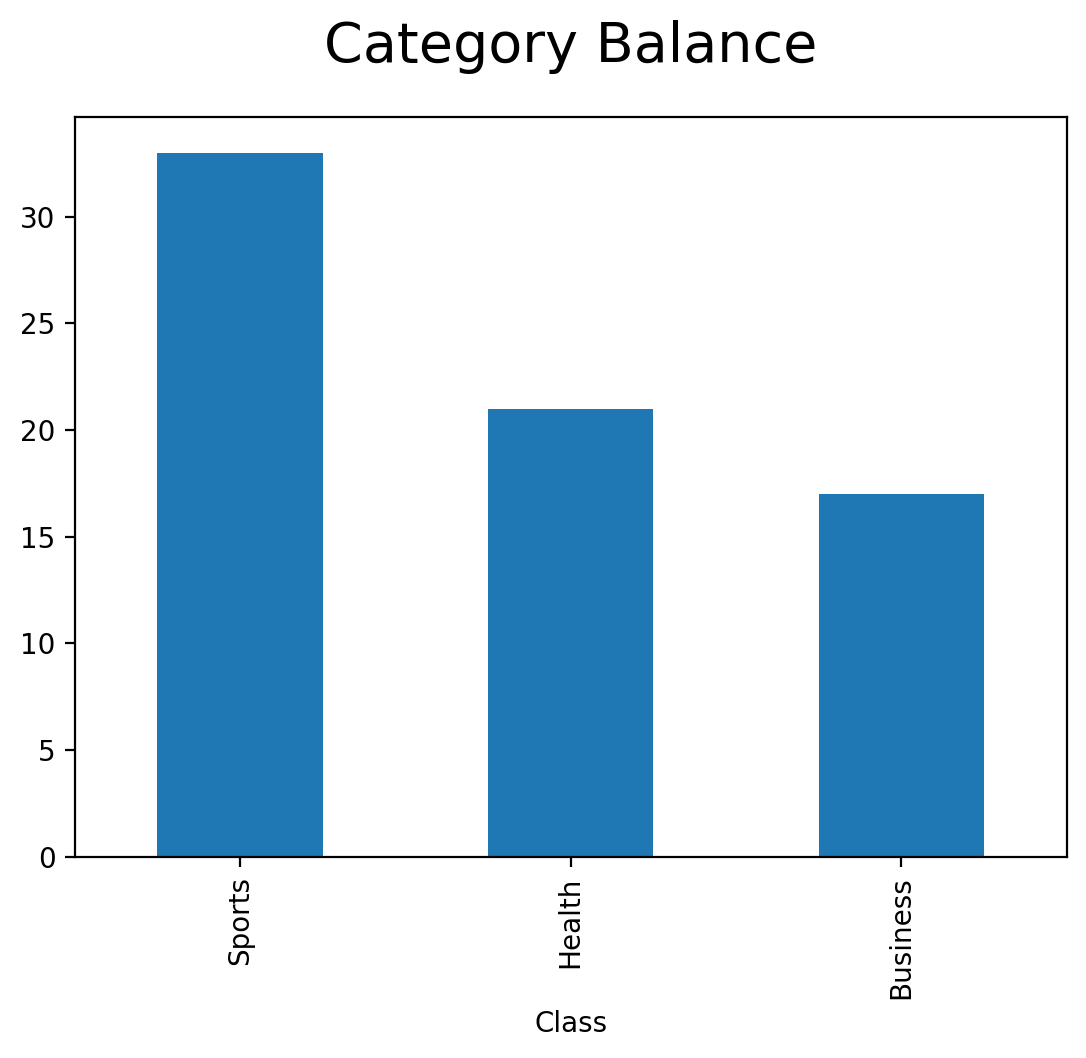

In [47]:
y_train.value_counts().plot(kind='bar')
plt.title('Category Balance', size=20, pad=20);

In [48]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(71,) (18,) (71,) (18,)


## 4.  Vectorize

In [49]:
vector = TfidfVectorizer(stop_words='english', 
                         ngram_range = (1,2),
                         min_df = 3,
                         max_df = 1.,
                         max_features = 10000)

## 5.  Construct Model

In [50]:
def fit_model(model, model_name):
    line = Pipeline([('vectorize', vector), (model_name, model)])
    
    output = cross_validate(line, 
                            X_train, 
                            y_train, 
                            cv = KFold(shuffle = True, 
                                       n_splits = 3,  
                                       random_state = 9),
                            scoring = ('accuracy', 'f1_weighted','precision_weighted','recall_weighted'),           
                            return_train_score=True)
    return output

In [51]:
dectree = fit_model(DecisionTreeClassifier(), 'DTree')
ridge = fit_model(RidgeClassifier(), 'Ridge')
bayes = fit_model(MultinomialNB(), 'NB')

dt = pd.DataFrame.from_dict(dectree)
rc = pd.DataFrame.from_dict(ridge)
bc = pd.DataFrame.from_dict(bayes)

In [52]:
l1 = [bc, rc, dt]
l2 =["NB", "Ridge", "DT"]

for each, tag in zip(l1, l2):
    each['model'] = [tag, tag, tag]

joined_output = pd.concat([bc,rc,dt])

In [53]:
dectree

{'fit_time': array([0.07333517, 0.03790665, 0.03793192]),
 'score_time': array([0.01444125, 0.01551366, 0.01196694]),
 'test_accuracy': array([0.75      , 0.625     , 0.91304348]),
 'train_accuracy': array([1., 1., 1.]),
 'test_f1_weighted': array([0.73846154, 0.62862319, 0.91788392]),
 'train_f1_weighted': array([1., 1., 1.]),
 'test_precision_weighted': array([0.77460317, 0.66185897, 0.94202899]),
 'train_precision_weighted': array([1., 1., 1.]),
 'test_recall_weighted': array([0.75      , 0.625     , 0.91304348]),
 'train_recall_weighted': array([1., 1., 1.])}

In [54]:
ridge

{'fit_time': array([0.05097985, 0.05191875, 0.04439974]),
 'score_time': array([0.01196766, 0.01648521, 0.01399899]),
 'test_accuracy': array([0.79166667, 0.95833333, 0.95652174]),
 'train_accuracy': array([1., 1., 1.]),
 'test_f1_weighted': array([0.78290598, 0.95809991, 0.95818757]),
 'train_f1_weighted': array([1., 1., 1.]),
 'test_precision_weighted': array([0.82222222, 0.96212121, 0.96521739]),
 'train_precision_weighted': array([1., 1., 1.]),
 'test_recall_weighted': array([0.79166667, 0.95833333, 0.95652174]),
 'train_recall_weighted': array([1., 1., 1.])}

In [55]:
bayes

{'fit_time': array([0.04252338, 0.03795171, 0.03586459]),
 'score_time': array([0.01192975, 0.01754212, 0.0169878 ]),
 'test_accuracy': array([0.58333333, 0.91666667, 1.        ]),
 'train_accuracy': array([0.9787234, 1.       , 1.       ]),
 'test_f1_weighted': array([0.56181818, 0.91524621, 1.        ]),
 'train_f1_weighted': array([0.97830622, 1.        , 1.        ]),
 'test_precision_weighted': array([0.74019608, 0.93055556, 1.        ]),
 'train_precision_weighted': array([0.97954173, 1.        , 1.        ]),
 'test_recall_weighted': array([0.58333333, 0.91666667, 1.        ]),
 'train_recall_weighted': array([0.9787234, 1.       , 1.       ])}

In [56]:
relevant_measures = list(['test_accuracy','test_precision_weighted', 'test_recall_weighted', 'test_f1_weighted'])

dec_tree_metrics = joined_output.loc[joined_output.model == 'DT'][relevant_measures]
nb_metrics = joined_output.loc[joined_output.model == 'NB'][relevant_measures]
r_metrics = joined_output.loc[joined_output.model == 'Ridge'][relevant_measures]

#### Decision Tree metrics

In [57]:
dec_tree_metrics

,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted
0,0.750000,0.774603,0.750000,0.738462
1,0.625000,0.661859,0.625000,0.628623
2,0.913043,0.942029,0.913043,0.917884


#### Multinomial Naive Bayes metrics

In [58]:
nb_metrics

,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted
0,0.583333,0.740196,0.583333,0.561818
1,0.916667,0.930556,0.916667,0.915246
2,1.000000,1.000000,1.000000,1.000000


#### Ridge Classifier metrics

In [59]:
r_metrics

,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted
0,0.791667,0.822222,0.791667,0.782906
1,0.958333,0.962121,0.958333,0.958100
2,0.956522,0.965217,0.956522,0.958188


#### Average metrics

In [60]:
metrics_ = [dec_tree_metrics, nb_metrics, r_metrics]
names_ = ['Decision Tree', 'Naive Bayes', 'Ridge Classifier']

for scores, namess in zip(metrics_, names_):
    print(f'{namess} Mean Metrics:')
    print(scores.mean())
    print('  ')

Decision Tree Mean Metrics:
test_accuracy              0.762681
test_precision_weighted    0.792830
test_recall_weighted       0.762681
test_f1_weighted           0.761656
dtype: float64
  
Naive Bayes Mean Metrics:
test_accuracy              0.833333
test_precision_weighted    0.890251
test_recall_weighted       0.833333
test_f1_weighted           0.825688
dtype: float64
  
Ridge Classifier Mean Metrics:
test_accuracy              0.902174
test_precision_weighted    0.916520
test_recall_weighted       0.902174
test_f1_weighted           0.899731
dtype: float64
  


### Selection of Model
From the metrics obtained above, we see that **Ridge Classifier** performs best. However, the **Multinomial Naive Bayes classifier** is chosen to create the final model.

This is because it **has the ability to provide probability score** for each prediction it makes, while scoring similarly to the best model.

In [61]:
# Join training and test datasets
X = pd.concat([X_train, 
               X_test])
y = pd.concat([y_train, 
               y_test])

In [62]:
def create_and_fit(clf, x, y):
    best_clf = clf
    pipeline = Pipeline([('vectorize', vector), ('model', best_clf)])
    return pipeline.fit(x, y)

In [63]:
# Create model
CLASSYfier = create_and_fit(MultinomialNB(), X, y)

In [64]:
CLASSYfier.classes_

array(['Business', 'Health', 'Sports'], dtype='<U8')

## FINAL TESTING:

The first sample text used is a tech news article about streaming services and video games. 

The classifier, if appropriate, should classify this as a tech text.

In [65]:
input_text = '(Reuters) -Netflix Inc said it would make a deeper dive into video games as the movie and TV streaming service projected weak subscriber growth amid growing competition and the lifting of pandemic restrictions that had kept people at home.'
CLASSYfier.predict_proba([input_text])

array([[0.1998378 , 0.37835237, 0.42180983]])

In [66]:
CLASSYfier.predict([input_text])[0]

'Sports'

Interestingly, since the streaming services are also businesses, the model reflects this with a `0.39` probability for the business category.

## GUI

In [67]:
import tkinter as tk
from tkinter.scrolledtext import ScrolledText


window = tk.Tk()


window.title("Subject Classification")
window.iconbitmap('favicon.ico')
window.minsize(600,400)

text_box = ScrolledText(window)
text_box.grid(column=0, row=1, padx=5, pady=5)

def result(res, pr):
    HEALTH = round(pr[0][0], 3)
    BUSINESS = round(pr[0][1], 3)
    SPORTS = round(pr[0][2], 3)
    
    lines = [f"Health: {HEALTH}", f"Business: {BUSINESS}", f"Sports: {SPORTS}"]
    tk.messagebox.showinfo(message= f"Predicted Category: {str(res).capitalize()}" + "\n\n\n"+"\n".join(lines))

def clickMe():
    classification = tk.StringVar()
    category_,probabilities = classify_text(text_box.get("1.0",tk.END))
    result(category_, probabilities)
    

def classify_text(input_text):
    out = CLASSYfier.predict([input_text])[0]
    probs = CLASSYfier.predict_proba([input_text])
    return out,probs

label = tk.Label(window, text = "Enter Text to be classified")
label.grid(column = 0, row = 0)

btn = tk.Button(window, text="Classify", command=clickMe)
btn.grid(column=0, row=2)
   



window.mainloop()

### Business Sample Text

Abstract of: **A global analysis of Private Investments in Public Equity**
by Dimitris Andriosopoulos, Styliani Panetsidou

source: https://pureportal.coventry.ac.uk/en/publications/a-global-analysis-of-private-investments-in-public-equity-2

>"Raising equity capital via Private Investments in Public Equity (PIPEs) has been rising in popularity, matching Seasoned Equity Offerings (SEOs). We use over 10,000 PIPEs in a global setting during 1995–2015 to assess how and through which channels institutional frameworks affect the issuers' performance. We document a significant decline in the market reaction, especially during 2004–2015 and find that firms issuing equity via PIPEs have significantly worse fundamentals. We also show that country governance matters as issuing firms operating in countries with better regulatory environments outperform others. Finally, we find that regulatory enforcement is a plausible underlying channel for the positive effect of the institutional frameworks on PIPEs performance."


source: 

### Arts Sample Text

Abstract of: **The Forever Man**
by Allen Stroud

source: https://pureportal.coventry.ac.uk/en/publications/the-forever-man

>One minute Andrew Pryde is in a library, reading; the next, he's staring at the body of a young girl lying between the bookshelves, with a policewoman standing over him. In the blink of an eye, his world has unravelled.
In his desperate quest to clear his name, he’ll have to suspend all disbelief. And who exactly is Ronald Gibbs, the nerdy youth with a dark twist, who seems to hold so many answers to the mystery? Could this strange man, who spends his days on Internet chatrooms trying to prove the existence of magic and other worlds, somehow be involved in the girl’s death?
All the while, Andrew is plagued by disturbing visions and nightmares. As the police close in, the two men are forced to band together to seek the truth about strange disappearances, portals, and the occult. Can they find the murderer and rescue a girl who’s already dead?

### Technology/Engineering Sample Text

Abstract of: **Characterization and compositional study of fibre laser processed engineering ceramics**
by P. P. Shukla, J. Lawrence

source: https://pureportal.coventry.ac.uk/en/publications/characterization-and-compositional-study-of-fibre-laser-processed

>Surface treatment by means of fibre laser radiation using various processing gas compositions was conducted on cold isostatic pressed (CIP) Si3N4 and ZrO2 engineering ceramics to observe changes in their surface integrity, chemical composition and distribution of the heat affected zone (HAZ). The as received and fibre laser treated surface topography was measured in 3D using white-light interferometry (WLI). Scanning electron microscopy (SEM) was then used to observe the microstructural integrity prior to and after the fibre laser treatment. Energy dispersive X-ray (EDX) was employed thereafter to detect the change in the chemical composition. Surface melting and distribution of the melt zone was found with all treated samples of Si3N4 and ZrO2. The surface finish and the material removal varied with using the various gas compositions. Fibre laser processing with N2 on Si3N4 proved to be the most influential in effecting morphology changes, whilst Ar with ZrO2 ceramics in order to locally melt and redistribute the top layer of ZrO 2 ceramics, producing a better bondage of the grain boundaries. However, the maximum materials removal was found with using O2 gas with both ceramics particularly with Si3N4 as the surface profile of the treated zone was completely modified. Effect of oxidation occurred with all samples but was less for ZrO2 ceramics in comparison with that of the Si3N4.